# Tutorial 1: Paleoclimate Proxies

**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Agustina Pesce, Zahra Khodakaramimaghsoud

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

### **Code and Data Sources**

Code for this tutorial is based on existing notebooks from LinkedEarth that [convert LiPD files to a Pandas dataframe](https://github.com/LinkedEarth/notebooks/blob/master/PAGES2k/01.lipd2df.ipynb) and [create a map of the PAGES2k network](https:///github.com/LinkedEarth/notebooks/blob/master/PAGES2k/02.plot_map.ipynb).

The following data is used in this tutorial:


*   PAGES2k Consortium. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). https://doi.org/10.1038/sdata.2017.88







# **Tutorial Objectives**

In this tutorial, you'll learn about different types of paleoclimate proxies (physical characteristics of the environment that can stand in for direct measurements) and how they can be used to reconstruct past variations in Earth's climate on various spatial and temporal timescales. In the process of exploring examples of proxy types and datasets, you'll also learn some fundamental skills for working with [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/), a Python package designed for the analysis of paleoclimate data.


By the end of this tutorial you will be able to:

*   Understand some types of paleoclimate proxies and archives that exist
*   Create a global map of locations of proxy paleoclimate records in a specific data network 



# Setup

In [1]:
# # Install libraries
# !pip install Pandas
# !pip install pooch
# !pip install matplotlib as plt

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [2]:
# !pip install --no-binary shapely shapely --force # Add this to use cartopy. in this way it doesn't crush
# !pip install cartopy

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.24.3-cp310-cp310-macosx_11_0_arm64.whl (13.9 MB)
  Created wheel for shapely: filename=shapely-2.0.1-cp310-cp310-macosx_11_0_arm64.whl size=308962 sha256=86075d940a2189bef3d5d09ac472c0d6380e4b5bd9ff411a627a22b8756e5d46
  Stored in directory: /Users/chi/Library/Caches/pip/wheels/07/bd/0

In [5]:
# !pip install LiPD

In [6]:
# Import libraries
import os
import pandas as pd
import numpy as np
import pooch # to donwload the  PAGES2K data
import matplotlib.pyplot as plt

import lipd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

## Common helper functions

In [8]:
# @title Convert the PAGES2K LiDP files into a pandas.DataFrame

# Function to convert the PAGES2K LiDP files in a pandas.DataFrame
def lipd2df(lipd_dirpath, pkl_filepath=None, col_str=[
            'paleoData_pages2kID',
            'dataSetName', 'archiveType',
            'geo_meanElev', 'geo_meanLat', 'geo_meanLon',
            'year', 'yearUnits',
            'paleoData_variableName',
            'paleoData_units',
            'paleoData_values',
            'paleoData_proxy']):
    """
    Convert a bunch of PAGES2k LiPD files to a `pandas.DataFrame` to boost data loading.

    If `pkl_filepath` isn't `None`, save the DataFrame as a pikle file.

    Parameters:
    ----------
        lipd_dirpath: str
          Path of the PAGES2k LiPD files
        pkl_filepath: str or None
          Path of the converted pickle file. Default: `None`
        col_str: list of str
          Name of the variables to extract from the LiPD files

    Returns:
    -------
        df: `pandas.DataFrame`
          Converted Pandas DataFrame
    """

    # Save the current working directory for later use, as the LiPD utility will change it in the background
    work_dir = os.getcwd()
    # LiPD utility requries the absolute path
    lipd_dirpath = os.path.abspath(lipd_dirpath)
    # Load LiPD files
    lipds = lipd.readLipd(lipd_dirpath)
    # Extract timeseries from the list of LiDP objects
    ts_list = lipd.extractTs(lipds)
    # Recover the working directory
    os.chdir(work_dir)
    # Create an empty pandas.DataFrame with the number of rows to be the number of the timeseries (PAGES2k records),
    # and the columns to be the variables we'd like to extract
    df_tmp = pd.DataFrame(index=range(len(ts_list)), columns=col_str)
    # Loop over the timeseries and pick those for global temperature analysis
    i = 0
    for ts in ts_list:
        if 'paleoData_useInGlobalTemperatureAnalysis' in ts.keys() and \
            ts['paleoData_useInGlobalTemperatureAnalysis'] == 'TRUE':
            for name in col_str:
                try:
                    df_tmp.loc[i, name] = ts[name]
                except:
                    df_tmp.loc[i, name] = np.nan
            i += 1
    # Drop the rows with all NaNs (those not for global temperature analysis)
    df = df_tmp.dropna(how='all')
    # Save the dataframe to a pickle file for later use
    if pkl_filepath:
        save_path = os.path.abspath(pkl_filepath)
        print(f'Saving pickle file at: {save_path}')
        df.to_pickle(save_path)
    return df

# Section 1: Convert PAGES2k LiPD files to a Pandas dataframe

As we've now seen from introductory video, there are various types of paleoclimate archives and proxies that can be used to reconstruct past changes in Earth's climate. For example:

- **Sediment Cores**: Sediments deposited in layers within lakes and oceans serve as a record of climate variations over time. Various proxies for past climate are preserved in sediment cores including, pollen, microfossils, charcoal, microscopic organisms, organic molecules, etc.
- **Ice Cores**: Similarly to sediment cores, ice cores capture past climate changes in layers of ice accumulated over time. Common proxies for reconstructing past climate in ice cores include water isotopes, greenhouse gas concentrations of air bubbles in the ice, and dust.
- **Corals**: Corals form annual growth bands within their carbonate skeletons, recording temperature changes over time. Scientists analyze the chemical composition of each layer to reconstruct temperature and salinity. Corals typically preserve relatively short paleoclimate records, but they provide very high-resolution reconstructions (monthly and seasonal) and are therefore valuable for understanding past changes in short-term phenomena.
- **Speleothems**: These are cave formations that result from the deposition of minerals from groundwater. As the water flows into the cave, thin layers of minerals (e.g., calcium carbonate), are deposited. The thickness and chemical composition of speleothem layers can be used to reconstruct climate changes in the past.
- **Tree Rings**: Each year, trees add a new layer of growth, known as a tree ring. These rings record changes in temperature and precipitation. Proxy measurements of tree rings include thickness and isotopes, which reflect annual variability in moisture and temperature

There are many existing paleoclimate reconstructions spanning a variety of timescales and from global locations. Given the temporal and spatial vastness of existing paleoclimate records, it can be challenging to know what paleoclimate data already exists and where to find it. One useful solution is compiling all existing paleoclimate records for a single climate variable (temperature, greenhouse gas concentration, precipitation, etc.) and over a specific time period (Holocene to present, the past 800,000 years, etc.). 

One example of this is the **PAGES2k network**, which is a community-sourced database of temperature-sensitive proxy records. The database consists of 692 records from 648 locations, that are from a variety of archives (e.g., trees, ice, sediment, corals, speleothems, etc.) and span the Common Era (1 CE to present, i.e., the past ~2,000 years). You can read more about the PAGES2k network, in [PAGES 2k Consortium (2017)](https://www.nature.com/articles/sdata201788).

In this tutorial, we will explore the types of proxy records in the PAGES2k network and create a map of proxy record locations.

## Section 1.1: Convert PAGES2k LiPD files to a Pandas dataframe

The PAGES2k network is stored in a specific file format known as Linked Paleo Data format (LiPD). LiPD files contain time series information in addition to supporting metadata (e.g., root metadata, location). Pyleoclim leverages this additional information using LiPD-specific functionality.

Data stored in the .lpd format can be loaded directly into Pyleoclim as a Lipd object. If the data_path points to one LiPD file, pyleo.Lipd will load the specific record, while if data_path points to a folder of lipd files, pyleo.Lipd will load the full set of records.

The first thing we need to do it to download the data and transform it into a DataFrame.

In [9]:
# Set the name to save the PAGES2K data
fname = "pages2k_data"

if not os.path.exists(fname):

    # Download the data
    lipd_file_paht = pooch.retrieve(
        url="https://ndownloader.figshare.com/files/8119937",
        known_hash=None,
        path="./",
        fname=fname,
        processor=pooch.Unzip()
    )

NOTE: when you run some of the next code cell to convert the Lipd files to a DataFrame, you will get some error messages. This is fine and the code will still accomplish what it needs to do. The code will also take a few minutes to, so if it's taking longer than you'd expect, that's alright!

In [10]:
# Convert all the lipd file in a DataFrame
fname = "pages2k_data"

pages2k_data = lipd2df(lipd_dirpath=os.path.join(".", f"{fname}.unzip", "LiPD_Files"), pkl_filepath=None)

Disclaimer: LiPD files may be updated and modified to adhere to standards

Found: 657 LiPD file(s)
reading: Ant-WDC05A.Steig.2013.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: Arc-Arjeplog.Bjorklund.2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
reading: NAm-co517.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dic

The PAGES2k data is now stored as a dataframe and we can view the data to understand different attributes it contains.

In [12]:
# Print the PAGES2K data
pages2k_data.head()

,paleoData_pages2kID,dataSetName,archiveType,geo_meanElev,geo_meanLat,geo_meanLon,year,yearUnits,paleoData_variableName,paleoData_units,paleoData_values,paleoData_proxy
0,Ant_006,Ant-WDC05A.Steig.2013,glacier ice,1806.0,-79.46,-112.09,"[2005.0, 2004.0, 2003.0, 2002.0, 2001.0, 2000....",AD,d18O,permil,"[-33.32873325, -35.6732, -33.1574, -34.2854, -...",d18O
1,Arc_065,Arc-Arjeplog.Bjorklund.2014,tree,800.0,66.3,18.2,"[1200.0, 1201.0, 1202.0, 1203.0, 1204.0, 1205....",AD,density,NA,"[-0.829089212152348, -0.733882889924006, -0.89...",delta Density
2,NAm_164,NAm-co517,tree,3320.0,40.1,-105.6,"[1610.0, 1611.0, 1612.0, 1613.0, 1614.0, 1615....",AD,MXD,NA,"[1.051, 0.992, 0.992, 1.071, 1.051, 1.011, 1.0...",MXD
3,Ocn_023,O2kLR-GreatBahamaBank.Lund.2006,marine sediment,-531.0,24.58,-79.26,"[1950.0, 1927.48, 1904.96, 1882.44, 1859.92, 1...",AD,temperature,degC,"[28.66, 28.28, 28.36, 28.38, 28.51, 28.32, 28....",foram Mg/Ca
4,Asi_060,Asia-HBHXJP,tree,2100.0,34.78,100.82,"[1500.0, 1501.0, 1502.0, 1503.0, 1504.0, 1505....",AD,trsgi,NA,"[0.73, 0.786, 0.818, 0.837, 0.823, 0.995, 1.15...",TRW


## Section 1.2: Plotting a map of proxy reconstruction locations

Now that we have converted the data into a Pandas dataframe, we can create a map. We are going to plot the PAGES2k network on a map to understand the spatial distribution of the temperature records and the types of proxies that were measured.

Before genereting the plot, we have to define the colours and the marker types that we want to use in the plot. We also need to set a list with the different `archive_type` names that appear in the data frame.

In [13]:
# Set a list of markers and colors for the different archive_type
markers = ['p', 'p', 'o', 'v', 'd', '*', 's', 's', '8', 'D', '^']
colors = [
    np.array([ 1., 0.83984375, 0.]),
    np.array([ 0.73828125, 0.71484375, 0.41796875]),
    np.array([ 1., 0.546875, 0.]),
    np.array([ 0.41015625, 0.41015625, 0.41015625]),
    np.array([ 0.52734375, 0.8046875 , 0.97916667]),
    np.array([ 0., 0.74609375, 1.]),
    np.array([ 0.25390625, 0.41015625, 0.87890625]),
    np.array([ 0.54296875, 0.26953125, 0.07421875]),
    np.array([ 1, 0, 0]),
    np.array([ 1., 0.078125  , 0.57421875]),
    np.array([ 0.1953125, 0.80078125, 0.1953125])
]

We are now going to create a plot that will allow us to see the PAGES2k network on a map.

/Users/chi/miniconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)


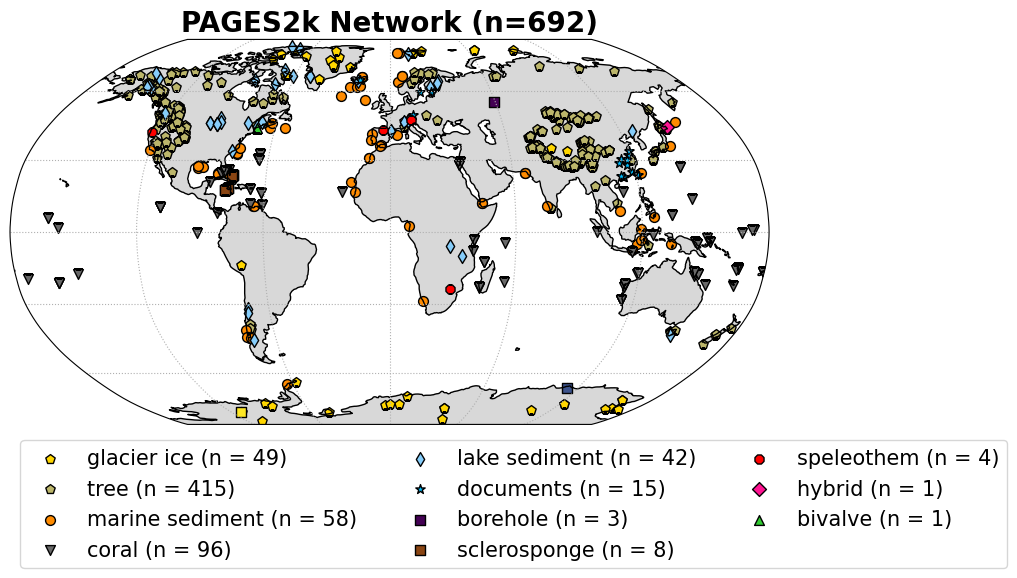

In [14]:
# Create the plot

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Add plot title
plt.title(f'PAGES2k Network (n={len(pages2k_data)})', fontsize=20, fontweight='bold')

# Set the base map
# ----------------
ax.set_global()
# Add coast lines
ax.coastlines()
# Add land fratures using gray color
ax.add_feature(cfeature.LAND, facecolor='gray', alpha=0.3)
ax.gridlines(edgecolor='gray', linestyle=':')


# Plot the different archive types
# -------------------------------
# Extract the name of the different archive types
archive_types = pages2k_data.archiveType.unique()
# Plot the archive_type using a forloop
for i, type_i in enumerate(archive_types):
    df = pages2k_data[pages2k_data['archiveType']==type_i]
    # Count the number of appearances of the same archive_type
    count = df['archiveType'].count()
    # Generate the plot
    ax.scatter(
        df['geo_meanLon'],
        df['geo_meanLat'],
        marker=markers[i],
        c=colors[i],
        edgecolor='k',
        s=50,
        transform=ccrs.Geodetic(),
        label=f'{type_i} (n = {count})',
    )
# Add legend to the plot
ax.legend(
    scatterpoints=1,
    bbox_to_anchor=(0, -0.4),
    loc='lower left',
    ncol=3,
    fontsize=15,
)

plt.show()

Now you can see the global distribution and temperature proxy type of the 692 records in the PAGES2k network!

What do you notice about the map?

*   Which temperature proxy is the most and least abundant in this database?
*   In what region do you observe the most and least temperature records? Why might this be the case?


In [15]:
## to remove explanation  
print ("""
The most abundant temperature proxy is tree and the least one is hybrid (tree/borehole) or bivalve. Tree rings form the basis for the majority (59%) of these records, and this can be attributed to their annual resolution, exact dating, and broad geographical distribution, most notably in the Northern Hemisphere's mid-latitudes.

The spatial distribution of proxy archives reveals an overwhelming distribution of records situated on land within the Northern Hemisphere.
""")


The most abundant temperature proxy is tree and the least one is hybrid (tree/borehole) or bivalve. Tree rings form the basis for the majority (59%) of these records, and this can be attributed to their annual resolution, exact dating, and broad geographical distribution, most notably in the Northern Hemisphere's mid-latitudes.

The spatial distribution of proxy archives reveals an overwhelming distribution of records situated on land within the Northern Hemisphere.



# **Summary**

In this tutorial, we've explored the PAGES2K network, which offers an extensive collection of proxy temperature reconstructions spanning the last 2,000 years. We've surveyed various types of paleoclimate proxies and archives available, in addition to crafting a global map pinpointing the locations of the PAGES2k proxy records.

We've been able to visualize the spatial distribution of paleoclimate temperature records that trace back two millennia. As we advance, the next step is to extract and meticulously analyze the temperature timelines embedded within these reconstructions.